# Brain Tumor Detection

[Dataset](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

In [ ]:
import os
import cv2
import numpy as np
import pathlib
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
import imutils

# Create the directory structure for augmented data
augmented_data_dir = 'augmented_data'
os.makedirs(augmented_data_dir, exist_ok=True)
yes_dir = os.path.join(augmented_data_dir, 'yes')
no_dir = os.path.join(augmented_data_dir, 'no')
os.makedirs(yes_dir, exist_ok=True)
os.makedirs(no_dir, exist_ok=True)

In [ ]:
# Original data paths
train_dir = '/content/drive/MyDrive/Data/brain_tumor_dataset'
train_dir = pathlib.Path(train_dir)
tumor_cells = list(train_dir.glob('yes/*'))
normal_cells = list(train_dir.glob('no/*'))

df_images = {
    'Tumor': tumor_cells,
    'Normal': normal_cells
}

df_labels = {
    'Tumor': 0,
    'Normal': 1
}

## Preprocessing Steps -
* Augmentation
* Standardization
* Resizing

In [ ]:
# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.5, 1.5)
)


In [ ]:
# Function to save augmented images
def save_augmented_images(label, images, save_dir, augment_size=7):
    for image_path in images:
        img = load_img(image_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images and save them
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix=label, save_format='jpg'):
            i += 1
            if i >= augment_size:
                break


In [ ]:
# Apply augmentation and save images
save_augmented_images('Tumor', tumor_cells, yes_dir, augment_size=7)
save_augmented_images('Normal', normal_cells, no_dir, augment_size=7)

In [ ]:
# Load original and augmented images
def load_images_and_labels(df_images, df_labels, augmented_data_dir):
    X, y = [], [] # X = images, y = labels

    # Load original images
    for label, images in df_images.items():
        for image in images:
            img = cv2.imread(str(image))
            #new_img = crop_img(img)
            resized_img = cv2.resize(img, (224, 224)) # Resizing the images
            X.append(resized_img)
            y.append(df_labels[label])

    # Load augmented images
    for label, folder in zip(['Tumor', 'Normal'], ['yes', 'no']):
        augmented_images_dir = os.path.join(augmented_data_dir, folder)
        augmented_images = list(pathlib.Path(augmented_images_dir).glob('*.jpg'))
        for image in augmented_images:
            img = cv2.imread(str(image))
            #cropped_img = crop_img(img)
            resized_img = cv2.resize(img, (224, 224))  # Resizing the images
            X.append(resized_img)
            y.append(df_labels[label])

    return np.array(X), np.array(y)


In [ ]:
# Load images and labels
X, y = load_images_and_labels(df_images, df_labels, augmented_data_dir)

In [ ]:
import numpy as np

np.unique(y)

array([0, 1])

In [ ]:
print(len(X))

1943


In [ ]:
# Standardizing
X = X / 255.0

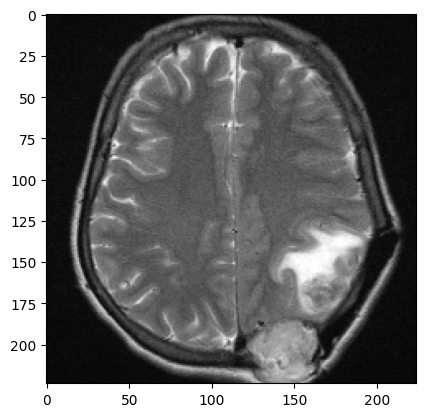

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X[2])

In [ ]:
from sklearn.model_selection import train_test_split

# Initial split into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (1165, 224, 224, 3)
Validation set size: (389, 224, 224, 3)
Test set size: (389, 224, 224, 3)


# Sequential Model with VGG16 base


In [ ]:
import tensorflow
from tensorflow.keras import models,layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load pre-trained VGG16 model without including the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Freeze the layers in the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a new model on top of the VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [ ]:
# Fit the model with validation data
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
37/37 [==============================] - 23s 294ms/step - loss: 0.7091 - accuracy: 0.6977 - val_loss: 0.9931 - val_accuracy: 0.5530
Epoch 2/10
37/37 [==============================] - 7s 193ms/step - loss: 0.4904 - accuracy: 0.7735 - val_loss: 0.3903 - val_accuracy: 0.8062
Epoch 3/10
37/37 [==============================] - 7s 191ms/step - loss: 0.2799 - accuracy: 0.8794 - val_loss: 0.2390 - val_accuracy: 0.9096
Epoch 4/10
37/37 [==============================] - 7s 195ms/step - loss: 0.2105 - accuracy: 0.9061 - val_loss: 0.2284 - val_accuracy: 0.9018
Epoch 5/10
37/37 [==============================] - 6s 161ms/step - loss: 0.1373 - accuracy: 0.9518 - val_loss: 0.1891 - val_accuracy: 0.9251
Epoch 6/10
37/37 [==============================] - 6s 169ms/step - loss: 0.0965 - accuracy: 0.9612 - val_loss: 0.3150 - val_accuracy: 0.8786
Epoch 7/10
37/37 [==============================] - 7s 194ms/step - loss: 0.0536 - accuracy: 0.9819 - val_loss: 0.2247 - val_accuracy: 0.9173
Epoch

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 [==============================] - 2s 118ms/step - loss: 0.1284 - accuracy: 0.9457
Test Loss: 0.12836425006389618
Test Accuracy: 0.9457364082336426


In [ ]:
# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    cropped_img = crop_img(img)
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized_img = resized_img / 255.0  # Normalize to [0, 1] range
    return normalized_img

# Function to classify the image
def classify_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    input_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
    prediction = model.predict(input_img)
    if prediction[0] < 0.5:
        print(prediction)
        return 'tumor'
    else:
        print(prediction)
        return 'normal'

In [ ]:
img3 = '/content/Y10.jpg'
result = classify_image(img3)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 22ms/step
[[0.0001875]]
The image is classified as: tumor


In [ ]:
img1 = '/content/y703.jpg'
result = classify_image(img1)
print(f"The image is classified as: {result}")

1/1 [==============================] - 1s 1s/step
[[0.97614187]]
The image is classified as: normal


In [ ]:
img2 ='/content/Te-no_0017.jpg'
result = classify_image(img2)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 18ms/step
[[0.64541507]]
The image is classified as: normal


In [ ]:
img3 ='/content/Te-no_0015.jpg'
result = classify_image(img3)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 27ms/step
[[0.00210878]]
The image is classified as: normal


# Sequential Model with ResNet50 base

In [ ]:
from keras.applications.resnet import ResNet50

resmodel= ResNet50(weights='imagenet', include_top=False, input_shape = (224,224,3))

base_model_2 = resmodel

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Freeze the layers in the base model (optional)
for layer in base_model_2.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model2 = Sequential()
model2.add(base_model_2)
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(128,activation='relu'))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
# Fit the model with validation data
history = model2.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
37/37 [==============================] - 18s 264ms/step - loss: 1.7148 - accuracy: 0.5719 - val_loss: 0.7953 - val_accuracy: 0.5995
Epoch 2/10
37/37 [==============================] - 5s 141ms/step - loss: 0.9887 - accuracy: 0.6133 - val_loss: 0.5527 - val_accuracy: 0.7003
Epoch 3/10
37/37 [==============================] - 5s 141ms/step - loss: 0.7289 - accuracy: 0.6400 - val_loss: 0.5629 - val_accuracy: 0.7313
Epoch 4/10
37/37 [==============================] - 5s 143ms/step - loss: 0.6428 - accuracy: 0.6675 - val_loss: 0.5111 - val_accuracy: 0.7623
Epoch 5/10
37/37 [==============================] - 5s 137ms/step - loss: 0.6195 - accuracy: 0.6770 - val_loss: 0.5117 - val_accuracy: 0.7752
Epoch 6/10
37/37 [==============================] - 5s 144ms/step - loss: 0.5973 - accuracy: 0.6873 - val_loss: 0.6688 - val_accuracy: 0.6072
Epoch 7/10
37/37 [==============================] - 5s 142ms/step - loss: 0.5862 - accuracy: 0.7063 - val_loss: 0.5054 - val_accuracy: 0.7700
Epoch

In [ ]:
# Evaluate the model on the test set
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss2}")
print(f"Test Accuracy: {test_accuracy2}")

13/13 [==============================] - 1s 92ms/step - loss: 0.5426 - accuracy: 0.7183
Test Loss: 0.5426053404808044
Test Accuracy: 0.7183462381362915


# CNN

In [ ]:
import tensorflow.keras.backend as K

# Clear previous sessions and models
#K.clear_session()


# defining 3rd model architecture

model3 = Sequential()
model3.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same", input_shape=(224, 224, 3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Flatten())
model3.add(Dense(units=128, activation="relu", kernel_initializer="he_uniform"))
model3.add(Dense(units=1, activation="sigmoid"))

# compile the model
model3.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# Fit the model with validation data
history3 = model3.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
37/37 [==============================] - 10s 77ms/step - loss: 2.2988 - accuracy: 0.6417 - val_loss: 0.6983 - val_accuracy: 0.5375
Epoch 2/10
37/37 [==============================] - 1s 39ms/step - loss: 0.5242 - accuracy: 0.7476 - val_loss: 0.5624 - val_accuracy: 0.7339
Epoch 3/10
37/37 [==============================] - 1s 35ms/step - loss: 0.4066 - accuracy: 0.8346 - val_loss: 0.5393 - val_accuracy: 0.7674
Epoch 4/10
37/37 [==============================] - 1s 39ms/step - loss: 0.2606 - accuracy: 0.8992 - val_loss: 0.5607 - val_accuracy: 0.7778
Epoch 5/10
37/37 [==============================] - 1s 41ms/step - loss: 0.1457 - accuracy: 0.9526 - val_loss: 0.6744 - val_accuracy: 0.7700
Epoch 6/10
37/37 [==============================] - 2s 43ms/step - loss: 0.0771 - accuracy: 0.9828 - val_loss: 0.7676 - val_accuracy: 0.7752
Epoch 7/10
37/37 [==============================] - 2s 45ms/step - loss: 0.0439 - accuracy: 0.9871 - val_loss: 0.8342 - val_accuracy: 0.7984
Epoch 8/10
3

In [ ]:
# Evaluate the model on the test set
test_loss3, test_accuracy3 = model3.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss3}")
print(f"Test Accuracy: {test_accuracy3}")

13/13 [==============================] - 0s 19ms/step - loss: 1.0178 - accuracy: 0.7907
Test Loss: 1.01779043674469
Test Accuracy: 0.7906976938247681


In [ ]:
# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    cropped_img = crop_img(img)
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized_img = resized_img / 255.0  # Normalize to [0, 1] range
    return normalized_img



In [ ]:
# Function to classify the image
def classify_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    input_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
    prediction = model3.predict(input_img)
    if prediction[0] < 0.5:
        print(prediction)
        return 'tumor'
    else:
        print(prediction)
        return 'normal'

In [ ]:
img1 = '/content/y703.jpg'
result = classify_image(img1)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 17ms/step
[[0.9419334]]
The image is classified as: tumor


In [ ]:
img2 ='/content/Te-no_0017.jpg'
result = classify_image(img2)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 17ms/step
[[0.5652458]]
The image is classified as: tumor


# Sequential Model with MobileNet base

In [ ]:
from keras.applications.mobilenet import MobileNet

# Load the MobileNet model
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

base_model_4 = mobilenet

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Freeze the layers in the base model (optional)
for layer in base_model_4.layers:
    layer.trainable = False

# Create a new model on top of the MobileNet base
model4 = Sequential()
model4.add(base_model_4)
model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(128,activation='relu'))
model4.add(Dense(64,activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model4.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               25690624  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
# Fit the model with validation data
history = model4.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
37/37 [==============================] - 10s 126ms/step - loss: 3.1342 - accuracy: 0.7091 - val_loss: 0.4427 - val_accuracy: 0.9169
Epoch 2/10
37/37 [==============================] - 2s 63ms/step - loss: 0.6364 - accuracy: 0.8883 - val_loss: 0.1991 - val_accuracy: 0.9532
Epoch 3/10
37/37 [==============================] - 2s 57ms/step - loss: 0.1874 - accuracy: 0.9558 - val_loss: 0.2325 - val_accuracy: 0.9558
Epoch 4/10
37/37 [==============================] - 2s 57ms/step - loss: 0.0822 - accuracy: 0.9801 - val_loss: 0.1315 - val_accuracy: 0.9636
Epoch 5/10
37/37 [==============================] - 2s 62ms/step - loss: 0.0338 - accuracy: 0.9913 - val_loss: 0.2271 - val_accuracy: 0.9532
Epoch 6/10
37/37 [==============================] - 2s 64ms/step - loss: 0.0278 - accuracy: 0.9913 - val_loss: 0.1909 - val_accuracy: 0.9506
Epoch 7/10
37/37 [==============================] - 2s 68ms/step - loss: 0.0138 - accuracy: 0.9939 - val_loss: 0.1196 - val_accuracy: 0.9766
Epoch 8/10


In [ ]:
# Evaluate the model on the test set
test_loss4, test_accuracy4 = model4.evaluate(X_test, y_test)

13/13 [==============================] - 1s 112ms/step - loss: 0.1950 - accuracy: 0.9456


In [ ]:
print(f"Test Loss: {test_loss4}")
print(f"Test Accuracy: {test_accuracy4}")

Test Loss: 0.19495955109596252
Test Accuracy: 0.9455958604812622


In [ ]:
# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    cropped_img = crop_img(img)
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized_img = resized_img / 255.0  # Normalize to [0, 1] range
    return normalized_img

# Function to classify the image
def classify_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    input_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
    prediction = model4.predict(input_img)
    if prediction[0] < 0.5:
        print(prediction)
        return 'tumor'
    else:
        print(prediction)
        return 'normal'


In [ ]:
img1 = '/content/Y1.jpg'
result = classify_image(img1)
print(f"The image is classified as: {result}")

1/1 [==============================] - 1s 938ms/step
[[2.5784414e-12]]
The image is classified as: tumor


In [ ]:
img2 ='/content/Te-no_0017.jpg'
result = classify_image(img2)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 45ms/step
[[0.58457893]]
The image is classified as: normal


# Sequential model with DenseNet121 Base

In [ ]:
from keras.applications.densenet import DenseNet121

densmodel= DenseNet121(weights='imagenet', include_top=False, input_shape = (224,224,3))

base_model_5 = densmodel

In [ ]:
# Freeze the layers in the base model (optional)
for layer in base_model_5.layers:
    layer.trainable = False

# Create a new model on top of the DenseNet base
model5 = Sequential()
model5.add(base_model_5)
model5.add(Flatten())
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(128,activation='relu'))
model5.add(Dense(64,activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 512)               25690624  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [ ]:
# Fit the model with validation data
history5 = model5.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/10
37/37 [==============================] - 30s 398ms/step - loss: 2.8361 - accuracy: 0.6575 - val_loss: 0.5878 - val_accuracy: 0.8252
Epoch 2/10
37/37 [==============================] - 5s 133ms/step - loss: 0.6182 - accuracy: 0.8403 - val_loss: 0.2708 - val_accuracy: 0.8895
Epoch 3/10
37/37 [==============================] - 5s 134ms/step - loss: 0.3915 - accuracy: 0.8755 - val_loss: 0.2733 - val_accuracy: 0.8895
Epoch 4/10
37/37 [==============================] - 5s 135ms/step - loss: 0.2116 - accuracy: 0.9167 - val_loss: 0.1747 - val_accuracy: 0.9306
Epoch 5/10
37/37 [==============================] - 5s 144ms/step - loss: 0.1442 - accuracy: 0.9399 - val_loss: 0.2181 - val_accuracy: 0.9177
Epoch 6/10
37/37 [==============================] - 7s 193ms/step - loss: 0.0989 - accuracy: 0.9665 - val_loss: 0.1424 - val_accuracy: 0.9280
Epoch 7/10
37/37 [==============================] - 5s 136ms/step - loss: 0.0772 - accuracy: 0.9751 - val_loss: 0.1940 - val_accuracy: 0.9280
Epoch

In [ ]:
# Evaluate the model on the test set
test_loss5, test_accuracy5 = model5.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss5}")
print(f"Test Accuracy: {test_accuracy5}")

13/13 [==============================] - 1s 94ms/step - loss: 0.1214 - accuracy: 0.9640
Test Loss: 0.12141220271587372
Test Accuracy: 0.9640102982521057


In [ ]:
# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    cropped_img = crop_img(img)
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized_img = resized_img / 255.0  # Normalize to [0, 1] range
    return normalized_img

# Function to classify the image
def classify_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    input_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
    prediction = model5.predict(input_img)
    if prediction[0] < 0.5:
        print(prediction)
        return 'tumor'
    else:
        print(prediction)
        return 'normal'

In [ ]:
img1 = '/content/Y1.jpg'
result = classify_image(img1)
print(f"The image is classified as: {result}")

1/1 [==============================] - 4s 4s/step
[[5.293991e-07]]
The image is classified as: tumor


In [ ]:
img2 ='/content/Te-no_0017.jpg'
result = classify_image(img2)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 34ms/step
[[0.97611517]]
The image is classified as: normal
